# ML Pipeline Preparation
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [ ]:
!pip install nltk
!pip install plotly

In [3]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/samyakj/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/samyakj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/samyakj/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
# import libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)

import sys
import os
import re
from sqlalchemy import create_engine
import pickle

from scipy.stats import gmean
# import relevant functions/modules from the sklearn
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.base import BaseEstimator,TransformerMixin

In [5]:
# load data from database
database_filepath = "../data/disaster_response_db.db"
engine = create_engine('sqlite:///' + database_filepath)
table_name = os.path.basename(database_filepath).replace(".db","") + "_table"
df = pd.read_sql_table(table_name,engine)

In [48]:
df.describe()

,id,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,26216.00000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000
mean,15224.82133,0.766478,0.170659,0.004501,0.414251,0.079493,0.050084,0.027617,0.017966,0.032804,0.063778,0.111497,0.088267,0.015449,0.023039,0.011367,0.033377,0.045545,0.131446,0.065037,0.045812,0.050847,0.020293,0.006065,0.010795,0.004577,0.011787,0.043904,0.278341,0.082202,0.093187,0.010757,0.093645,0.020217,0.052487,0.193584
std,8826.88914,0.423079,0.376218,0.066940,0.492602,0.270513,0.218122,0.163875,0.132831,0.178128,0.244361,0.314752,0.283688,0.123331,0.150031,0.106011,0.179621,0.208500,0.337894,0.246595,0.209081,0.219689,0.141003,0.077643,0.103338,0.067502,0.107927,0.204887,0.448191,0.274677,0.290700,0.103158,0.291340,0.140743,0.223011,0.395114
min,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7446.75000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15662.50000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,22924.25000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30265.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [56]:
df[df.death == 1].message[72]

'some people are sleeping outside on a field at Lilavois 50 and are dying of hunger since January 12th.'

<AxesSubplot:>

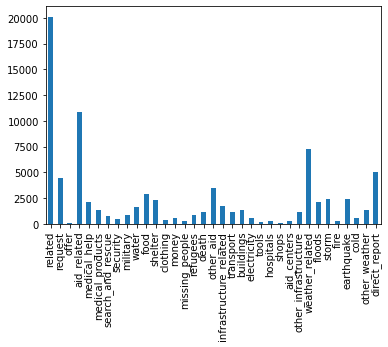

In [43]:
df.iloc[:, 4:].sum().plot(kind="bar")

In [7]:
#Remove child alone as it has all zeros only
df = df.drop(['child_alone'],axis=1)

In [8]:
df.groupby("related").count()

,id,message,original,genre,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
related,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,6122,6122,3395,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122
1,19906,19906,6643,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906
2,188,188,132,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188


In [9]:
# Given value 2 in the related field are neglible so it could be error. Replacing 2 with 1 to consider it a valid response.
# Alternatively, we could have assumed it to be 0 also. In the absence of information I have gone with majority class.
df['related']=df['related'].map(lambda x: 1 if x == 2 else x)

In [10]:
# Extract X and y variables from the data for the modelling
X = df['message']
y = df.iloc[:,4:]

### 2. Tokenization function to process text data

In [11]:
def tokenize(text,url_place_holder_string="urlplaceholder"):
    """
    Tokenize the text function
    
    Arguments:
        text -> Text message which needs to be tokenized
    Output:
        clean_tokens -> List of tokens extracted from the provided text
    """
    
    # Replace all urls with a urlplaceholder string
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    
    # Extract all the urls from the provided text 
    detected_urls = re.findall(url_regex, text)
    
    # Replace url with a url placeholder string
    for detected_url in detected_urls:
        text = text.replace(detected_url, url_place_holder_string)

    # Extract the word tokens from the provided text
    tokens = nltk.word_tokenize(text)
    
    #Lemmanitizer to remove inflectional and derivationally related forms of a word
    lemmatizer = nltk.WordNetLemmatizer()

    # List of clean tokens
    clean_tokens = [lemmatizer.lemmatize(w).lower().strip() for w in tokens]
    return clean_tokens

In [12]:
# Custom transformer which will extract the starting verb of a sentence
class StartingVerbExtractor(BaseEstimator, TransformerMixin):
    """
    Starting Verb Extractor class
    
    This class extract the starting verb of a sentence,
    creating a new feature for the ML classifier
    """

    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            first_word, first_tag = pos_tags[0]
            if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                return True
        return False

    # Given it is a tranformer we can return the self 
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)

### 3. Machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. 

In [13]:
pipeline1 = Pipeline([
        ('features', FeatureUnion([

            ('text_pipeline', Pipeline([
                ('count_vectorizer', CountVectorizer(tokenizer=tokenize)),
                ('tfidf_transformer', TfidfTransformer())
            ]))
            
        ])),

        ('classifier', MultiOutputClassifier(AdaBoostClassifier()))
    ])

pipeline2 = Pipeline([
        ('features', FeatureUnion([

            ('text_pipeline', Pipeline([
                ('count_vectorizer', CountVectorizer(tokenizer=tokenize)),
                ('tfidf_transformer', TfidfTransformer())
            ])),

            ('starting_verb_transformer', StartingVerbExtractor())
        ])),

        ('classifier', MultiOutputClassifier(AdaBoostClassifier()))
    ])


#pipeline = Pipeline(
#                    [('count_vectorizer', CountVectorizer(tokenizer = tokenize)),
#                     ('tfidf_transformer', TfidfTransformer()),
#                     ('rf_classifier', RandomForestClassifier())
#                     ])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
pipeline_fitted = pipeline1.fit(X_train, y_train)

### 5. Test model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [16]:
y_prediction_train = pipeline_fitted.predict(X_train)
y_prediction_test = pipeline_fitted.predict(X_test)

# Print classification report on test data
print(classification_report(y_test.values, y_prediction_test, target_names=y.columns.values))

                        precision    recall  f1-score   support

               related       0.82      0.94      0.88      5006
               request       0.78      0.52      0.63      1123
                 offer       0.12      0.03      0.05        30
           aid_related       0.76      0.59      0.67      2704
          medical_help       0.64      0.24      0.35       537
      medical_products       0.64      0.30      0.40       352
     search_and_rescue       0.72      0.22      0.34       174
              security       0.33      0.07      0.11       118
              military       0.66      0.30      0.41       219
                 water       0.70      0.65      0.68       409
                  food       0.79      0.70      0.74       716
               shelter       0.76      0.55      0.64       529
              clothing       0.72      0.46      0.56       104
                 money       0.48      0.25      0.33       142
        missing_people       0.58      

/home/samyakj/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/samyakj/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
# Print classification report on training data
print('\n',classification_report(y_train.values, y_prediction_train, target_names=y.columns.values))


                         precision    recall  f1-score   support

               related       0.83      0.94      0.88     15088
               request       0.80      0.54      0.65      3351
                 offer       0.55      0.14      0.22        88
           aid_related       0.77      0.61      0.68      8156
          medical_help       0.66      0.29      0.40      1547
      medical_products       0.71      0.34      0.46       961
     search_and_rescue       0.66      0.21      0.32       550
              security       0.47      0.07      0.13       353
              military       0.69      0.35      0.46       641
                 water       0.78      0.66      0.71      1263
                  food       0.81      0.71      0.75      2207
               shelter       0.81      0.55      0.66      1785
              clothing       0.77      0.45      0.57       301
                 money       0.65      0.34      0.44       462
        missing_people       0.74    

/home/samyakj/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/samyakj/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 6. Improve model
Grid search to find better parameters. 

In [19]:
# pipeline1.get_params().keys()
parameters_grid = {'classifier__estimator__learning_rate': [0.01, 0.02, 0.05],
              'classifier__estimator__n_estimators': [10, 20, 40]}

#parameters_grid = {'classifier__estimator__n_estimators': [10, 20, 40]}

cv = GridSearchCV(pipeline1, param_grid=parameters_grid, scoring='f1_micro', n_jobs=-1)
cv.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('text_pipeline',
                                                                        Pipeline(steps=[('count_vectorizer',
                                                                                         CountVectorizer(tokenizer=<function tokenize at 0x7fc373711160>)),
                                                                                        ('tfidf_transformer',
                                                                                         TfidfTransformer())]))])),
                                       ('classifier',
                                        MultiOutputClassifier(estimator=AdaBoostClassifier()))]),
             n_jobs=-1,
             param_grid={'classifier__estimator__learning_rate': [0.01, 0.02,
                                                                  0.05],
                         'classifier__est

In [21]:
# Get the prediction values from the grid search cross validator
y_prediction_test = cv.predict(X_test)
y_prediction_train = cv.predict(X_train)

### 7. Test model
Accuracy, precision, and recall of the tuned model.  


In [22]:
# Print classification report on test data
print(classification_report(y_test.values, y_prediction_test, target_names=y.columns.values))

                        precision    recall  f1-score   support

               related       0.76      1.00      0.87      5006
               request       0.60      0.38      0.46      1094
                 offer       0.00      0.00      0.00        29
           aid_related       0.80      0.19      0.31      2662
          medical_help       0.57      0.10      0.18       557
      medical_products       0.70      0.14      0.24       326
     search_and_rescue       0.62      0.19      0.29       167
              security       0.00      0.00      0.00       107
              military       0.25      0.01      0.01       190
                 water       0.59      0.84      0.69       436
                  food       0.78      0.69      0.73       715
               shelter       0.84      0.31      0.46       569
              clothing       1.00      0.01      0.02       100
                 money       0.55      0.18      0.27       159
        missing_people       0.55      

/home/samyakj/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/samyakj/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# Print classification report on training data
print('\n',classification_report(y_train.values, y_prediction_train, target_names=y.columns.values))


                         precision    recall  f1-score   support

               related       0.77      1.00      0.87     15088
               request       0.61      0.38      0.47      3380
                 offer       1.00      0.02      0.04        89
           aid_related       0.80      0.19      0.31      8198
          medical_help       0.66      0.12      0.20      1527
      medical_products       0.73      0.12      0.21       987
     search_and_rescue       0.64      0.19      0.29       557
              security       0.00      0.00      0.00       364
              military       0.33      0.00      0.00       670
                 water       0.57      0.85      0.68      1236
                  food       0.77      0.68      0.72      2208
               shelter       0.84      0.29      0.43      1745
              clothing       0.50      0.00      0.01       305
                 money       0.56      0.16      0.24       445
        missing_people       0.71    

/home/samyakj/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/samyakj/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 8. Improving the model further:
* other machine learning algorithms
* add other features besides the TF-IDF

In [24]:
#cv.best_params_

# pipeline2 which includes StartingVerbEstimator
X_train, X_test, y_train, y_test = train_test_split(X, y)
pipeline_fitted = pipeline2.fit(X_train, y_train)

y_prediction_train = pipeline_fitted.predict(X_train)
y_prediction_test = pipeline_fitted.predict(X_test)

# Print classification report on test data
print(classification_report(y_test.values, y_prediction_test, target_names=y.columns.values))

                        precision    recall  f1-score   support

               related       0.83      0.94      0.88      5038
               request       0.80      0.53      0.64      1151
                 offer       0.00      0.00      0.00        31
           aid_related       0.76      0.60      0.67      2710
          medical_help       0.56      0.21      0.30       528
      medical_products       0.68      0.35      0.46       332
     search_and_rescue       0.55      0.21      0.31       174
              security       0.37      0.11      0.17       102
              military       0.61      0.30      0.41       197
                 water       0.74      0.66      0.70       436
                  food       0.81      0.68      0.74       763
               shelter       0.77      0.55      0.64       562
              clothing       0.80      0.40      0.53        98
                 money       0.50      0.25      0.33       137
        missing_people       0.39      

/home/samyakj/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/samyakj/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/samyakj/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
# Print classification report on training data
print('\n',classification_report(y_train.values, y_prediction_train, target_names=y.columns.values))


                         precision    recall  f1-score   support

               related       0.83      0.95      0.88     15056
               request       0.79      0.55      0.65      3323
                 offer       0.62      0.11      0.19        87
           aid_related       0.77      0.60      0.68      8150
          medical_help       0.67      0.29      0.41      1556
      medical_products       0.71      0.35      0.47       981
     search_and_rescue       0.73      0.22      0.34       550
              security       0.46      0.08      0.14       369
              military       0.67      0.34      0.45       663
                 water       0.77      0.68      0.72      1236
                  food       0.82      0.69      0.75      2160
               shelter       0.80      0.55      0.65      1752
              clothing       0.77      0.45      0.57       307
                 money       0.64      0.34      0.44       467
        missing_people       0.72    

/home/samyakj/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/samyakj/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 9. Export model as a pickle file

In [26]:
m = pickle.dumps('classifier.pkl')

### 10. Script
`train_classifier.py` is the script that runs the steps above to create a database and export a model based on a new dataset specified by the user.